In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import math

import umap
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)

from scipy.stats import chi2

from config.regime_tickers import custom_vol_subset

# For Alpaca API
from datetime import datetime
from zoneinfo import ZoneInfo

from alpaca.data.timeframe import TimeFrame, TimeFrameUnit
from alpaca.data.historical.stock import StockHistoricalDataClient

from alpaca.data.requests import (
    StockBarsRequest
)

from alpaca.data.enums import Adjustment

# to run async code in jupyter notebook
import nest_asyncio
nest_asyncio.apply()

# For API Keys
import os
from dotenv import load_dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
API_KEY = None
SECRET_KEY = None

load_dotenv(override=True)

if API_KEY is None:
    API_KEY = os.environ.get('ALP_API_KEY')

if SECRET_KEY is None:
    SECRET_KEY = os.environ.get('ALP_SEC_KEY')

In [88]:
stock_historical_data_client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

# alpaca has no older data than 2016-01-04 for this symbol set
earliest_date = datetime(2016, 1, 4, tzinfo=ZoneInfo('America/New_York'))
# earliest_timestamps_by_symbol = df_adj.reset_index().groupby('symbol')['timestamp'].min()

req = StockBarsRequest(
    symbol_or_symbols = custom_vol_subset, 
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date,                    
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_adj = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_adj = df_adj.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs


In [89]:
print("Total NANs:", df_adj.pivot(columns="symbol").isna().sum().sum())

Total NANs: 0


In [90]:
# Calculate Daily Log Returns
df_adj['log_returns'] = df_adj.groupby('symbol')['close'].transform(lambda x: np.log(x / x.shift(1)))

In [91]:
# Rolling Standard Deviation (Volatility). For further computations only, not for raw variables
windows = [20]

for w in windows:
    df_adj[f'rolling_std_20'] = df_adj.groupby('symbol')['log_returns'].transform(
        lambda x: x.rolling(window=w, min_periods=w).std()
    )

In [92]:
df_adj = df_adj.sort_values(by=['symbol', 'timestamp'])

In [93]:
df_pivot = df_adj.pivot(columns="symbol")
# Flatten columns ('close', 'QQQ') -> 'close_QQQ'
df_pivot.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_pivot.columns]

In [94]:
# Volatility Cross-Asset Dispersion lets you measure how much the volatility levels themselves are diverging across assets. It's like saying: are
#  all sectors jittery together or are some calm while others are chaotic? Great for reading the market’s internal stress or divergence.

bond_tickers = ["TLT", "HYG"] 
ex_us_tickers = ["VWO", "VEA"]

# Step 1: Filter only the 'rolling_std_20' columns
rolling_std_cols = [col for col in df_pivot.columns if col.startswith('rolling_std_20_')]

# Step 2: Compute cross-sectional std (dispersion) across symbols for each timestamp
bond_tickers_cols = [f"rolling_std_20_{symbol}" for symbol in bond_tickers if f"rolling_std_20_{symbol}" in rolling_std_cols]
ex_us_tickers_cols = [f"rolling_std_20_{symbol}" for symbol in ex_us_tickers if f"rolling_std_20_{symbol}" in rolling_std_cols]

# Compute dispersion 
vol_disp_bond = df_pivot[bond_tickers_cols].std(axis=1)
df_pivot["z_vol_dispersion_bond"] = (vol_disp_bond - vol_disp_bond.mean()) / vol_disp_bond.std()

vol_disp_ex_us = df_pivot[ex_us_tickers_cols].std(axis=1)
df_pivot["z_vol_dispersion_ex_us"] = (vol_disp_ex_us - vol_disp_ex_us.mean()) / vol_disp_ex_us.std()

In [95]:
# Realized Vol / Implied Vol compares actual historical price movement (realized vol) with what the market expects (implied vol). 
# A ratio >1 means realized volatility has exceeded market expectations — a sign of surprise, dislocation, or a catch-up in pricing. 
# A ratio <1 suggests implied vol is elevated — often in times of uncertainty or hedging demand.

# Z-realized vs Implied Volatility Ratios

# Reference realized vol
realized = df_pivot['rolling_std_20_IWM']

# Loop over each implied asset and compute z-scored realized/implied ratios
implied = df_pivot['rolling_std_20_VIXY']
ratio = realized / implied
z_col = f'z_realized_implied_vixy'

z_window = 60
df_pivot[z_col] = (ratio - ratio.rolling(z_window).mean()) / ratio.rolling(z_window).std()

In [96]:
# Volatility Spread = VIXY implied vol proxy – realized vol of SPY/IWM
# Z-score Level	What It Means
# > +2	Implied vol (VIXY) is much higher than realized vol → Fear spike
# < -2	Realized vol is unusually high vs what’s priced in → Complacency mispricing?
# Around 0	Implied and realized vol are in sync → Stable regime

# Step 1: Compute average realized vol of SPY and IWM
realized_avg = df_pivot[['rolling_std_20_SPY', 'rolling_std_20_IWM']].mean(axis=1)

# Step 2–4: Loop over implied assets to compute z-scored spread and clean up
spread = df_pivot['rolling_std_20_VIXY'] - realized_avg
z_col = f'z_vol_spread_vixy'

df_pivot[z_col] = (spread - spread.rolling(z_window).mean()) / spread.rolling(z_window).std()

In [97]:
# Volatility Skew = Difference in realized vol between two symbols
# IWM vs SPY — Small Caps vs Broad Market - GLD vs SPY — Gold vs Broad Market
# Define the assets to compare against SPY
skew_assets = ['XBI']

# Loop to compute z-scored volatility skew vs SPY
for ticker in skew_assets:
    spread = df_pivot[f'rolling_std_20_{ticker}'] - df_pivot['rolling_std_20_SPY']
    z_col = f'z_vol_skew_{ticker.lower()}'
    
    df_pivot[z_col] = (spread - spread.rolling(z_window).mean()) / spread.rolling(z_window).std()

In [98]:
# after 2*max(windows) +z_window -1 days, not nans
nan_range_start = max(windows)+z_window-1
print(df_pivot[nan_range_start:].isna().sum().sum()) 

df_pivot_clean = df_pivot[nan_range_start:]

0


In [ ]:
# Remove not useful/noisy columns
df_pivot_clean = df_pivot_clean.drop(
    columns=[col for col in df_pivot_clean.columns if any(x in col for x in ["open", "high", "low", "close", "volume", "trade_count", "vwap", "rolling_std", "log_returns"])]
)

In [100]:
df_pivot_clean.columns

Index(['z_vol_dispersion_bond', 'z_vol_dispersion_ex_us',
       'z_realized_implied_vixy', 'z_vol_spread_vixy', 'z_vol_skew_xbi'],
      dtype='object')

In [101]:
N_COMP=3
N_NEIG=15
MIN_D = 0.01
METRIC = "correlation" 
K = 3

RANDOM_STATE = 45

In [ ]:
# Scale and apply UMAP
scaled = MinMaxScaler().fit_transform(df_pivot_clean)
X_umap = umap.UMAP(n_neighbors=N_NEIG, min_dist=MIN_D, n_components=N_COMP, metric=METRIC, random_state=RANDOM_STATE).fit_transform(scaled)

silhouette_scores = []
ch_scores = []
db_scores = []

gmm = GaussianMixture(n_components=K, init_params="k-means++", random_state=RANDOM_STATE)
gmm_labels = gmm.fit_predict(X_umap)

print("gmm", {
    "silhouette": silhouette_score(X_umap, gmm_labels),
    "calinski_harabasz": calinski_harabasz_score(X_umap, gmm_labels),
    "davies_bouldin": davies_bouldin_score(X_umap, gmm_labels)
})

c:\Users\sergi\Documents\TFG\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


gmm {'silhouette': 0.5449206233024597, 'calinski_harabasz': 3675.365966796875, 'davies_bouldin': 0.6727578613801498}


In [ ]:
### Save scaler, umap, and gmm model
# import joblib

# # Define model directory
# MODEL_DIR = "models"
# os.makedirs(MODEL_DIR, exist_ok=True)

# # Save the scaler
# scaler = MinMaxScaler().fit(df_pivot_clean)
# joblib.dump(scaler, os.path.join(MODEL_DIR, "vol_scaler.pkl"))

# # Save the fitted UMAP model
# umap_model = umap.UMAP(
#     n_neighbors=N_NEIG,
#     min_dist=MIN_D,
#     n_components=N_COMP,
#     metric=METRIC,
#     random_state=RANDOM_STATE
# ).fit(scaled)
# joblib.dump(umap_model, os.path.join(MODEL_DIR, "vol_umap_model.pkl"))

# # Save the trained GMM model
# joblib.dump(gmm, os.path.join(MODEL_DIR, "vol_gmm_model.pkl"))


# ## If want to predict
# # Load models
# scaler = joblib.load(os.path.join(MODEL_DIR, "vol_scaler.pkl"))
# umap_model = joblib.load(os.path.join(MODEL_DIR, "vol_umap_model.pkl"))
# gmm_model = joblib.load(os.path.join(MODEL_DIR, "vol_gmm_model.pkl"))

# # Preprocess new data
# new_scaled = scaler.transform(new_data)

# # Apply UMAP transformation
# new_umap = umap_model.transform(new_scaled)

# # Predict clusters
# new_labels = gmm_model.predict(new_umap)


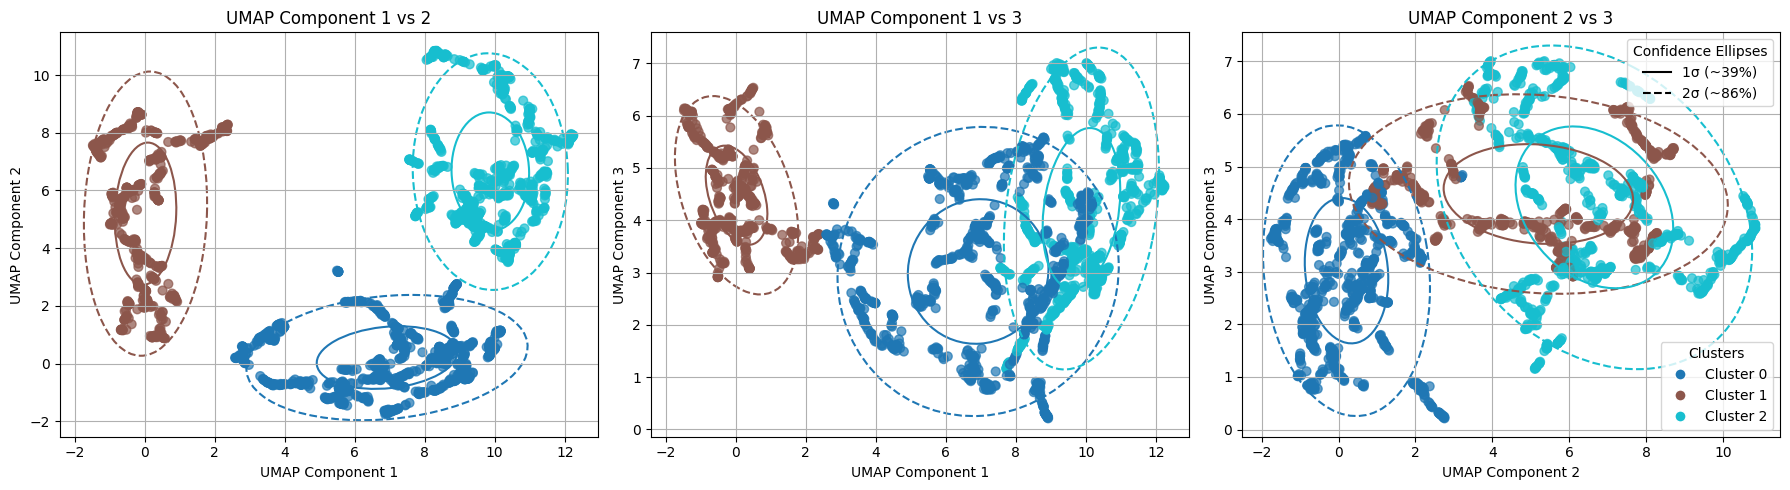

In [ ]:
# Define component pairs for plotting
component_pairs = [(0, 1), (0, 2), (1, 2)]
titles = [
    "UMAP Component 1 vs 2",
    "UMAP Component 1 vs 3",
    "UMAP Component 2 vs 3"
]

def plot_gmm_std_ellipses(ax, gmm, comp_x, comp_y, colors):

    std_levels = [1, 2]
    chi2_vals = [chi2.ppf(0.3935, df=2), chi2.ppf(0.8647, df=2)]
    scales = [np.sqrt(val) for val in chi2_vals]

    for i, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
        if covar.ndim == 1:  # spherical
            cov = np.diag(covar)
        elif covar.ndim == 2:  # full or tied
            cov = covar
        else:
            continue

        # Project to 2D
        sub_cov = cov[np.ix_([comp_x, comp_y], [comp_x, comp_y])]
        sub_mean = mean[[comp_x, comp_y]]

        # Eigen decomposition
        vals, vecs = np.linalg.eigh(sub_cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        for scale, std in zip(scales, std_levels):
            width, height = 2 * scale * np.sqrt(vals)

            if std == 1:
                linestyle = '-'
            elif std == 2:
                linestyle = '--'
            else:
                linestyle = ':'

            ellipse = Ellipse(
                sub_mean, width, height, angle=theta,
                edgecolor=colors[i], facecolor='none', lw=1.5, linestyle=linestyle
            )
            ax.add_patch(ellipse)


# Define colors for ellipses
colors = plt.cm.tab10(np.linspace(0, 1, K))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (comp_x, comp_y) in enumerate(component_pairs):
    ax = axes[i]
    scatter = ax.scatter(
        X_umap[:, comp_x], X_umap[:, comp_y],
        c=gmm_labels, cmap='tab10', s=40, alpha=0.7
    )
    ax.set_xlabel(f'UMAP Component {comp_x + 1}')
    ax.set_ylabel(f'UMAP Component {comp_y + 1}')
    ax.set_title(titles[i])
    ax.grid(True)

    # Plot GMM ellipses
    plot_gmm_std_ellipses(ax, gmm, comp_x, comp_y, colors)

# Add legend to the last plot
custom_lines = [
    Line2D([0], [0], color='black', lw=1.5, linestyle='-'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--'),
    Line2D([0], [0], color='black', lw=1.5, linestyle=':')
]
confidence_legend = axes[-1].legend(custom_lines, ['1σ (~39%)', '2σ (~86%)'], loc="upper right", title="Confidence Ellipses")

# Add first legend for confidence ellipses
axes[-1].add_artist(confidence_legend) 

# Create second legend for clusters
cluster_handles = [
    Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}',
           markerfacecolor=colors[i], markersize=8)
    for i in range(K)
]
cluster_legend = axes[-1].legend(handles=cluster_handles, loc='lower right', title="Clusters")


plt.tight_layout()
plt.show()

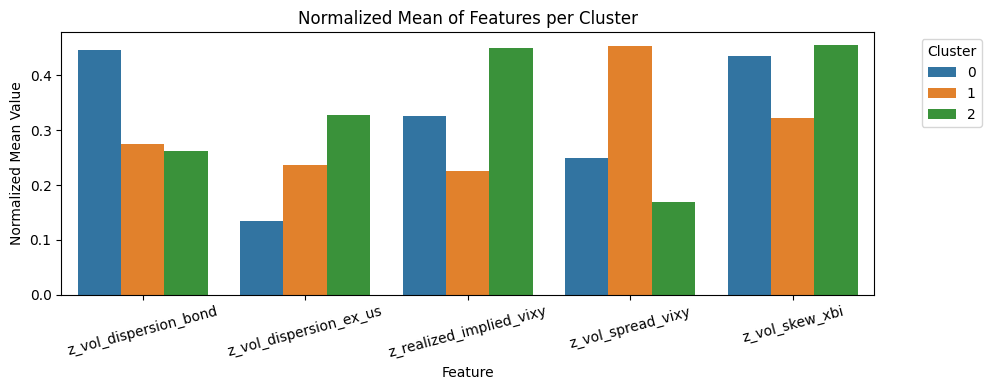

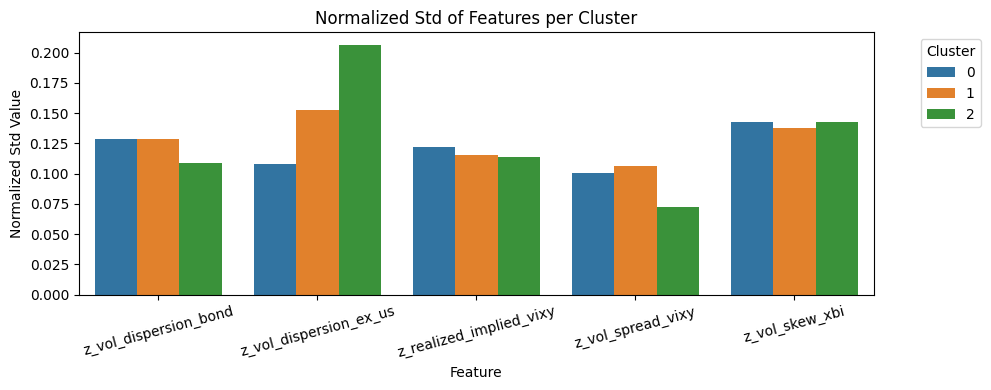

In [ ]:
df_normalized = pd.DataFrame(scaled, columns=df_pivot_clean.columns, index=df_pivot_clean.index)

# Assign cluster labels
df_normalized['Cluster'] = gmm_labels

# Calculate mean value per feature per cluster
mean_per_cluster = df_normalized.groupby('Cluster').mean().T  # Transpose to get features as rows

# Melt the data for grouped barplot
melted = mean_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Normalized Mean')
melted = melted.rename(columns={'index': 'Feature'})

# Plot grouped barplot
plt.figure(figsize=(10, 4))
sns.barplot(x='Feature', y='Normalized Mean', hue='Cluster', data=melted, palette='tab10')

plt.title('Normalized Mean of Features per Cluster')
plt.xlabel('Feature')
plt.ylabel('Normalized Mean Value')
plt.xticks(rotation=15)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calculate std value per feature per cluster
std_per_cluster = df_normalized.groupby('Cluster').std().T  # Transpose to get features as rows

# Melt the data for grouped barplot
melted = std_per_cluster.reset_index().melt(id_vars='index', var_name='Cluster', value_name='Normalized Std')
melted = melted.rename(columns={'index': 'Feature'})

# Plot grouped barplot
plt.figure(figsize=(10, 4))
sns.barplot(x='Feature', y='Normalized Std', hue='Cluster', data=melted, palette='tab10')

plt.title('Normalized Std of Features per Cluster')
plt.xlabel('Feature')
plt.ylabel('Normalized Std Value')
plt.xticks(rotation=15)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


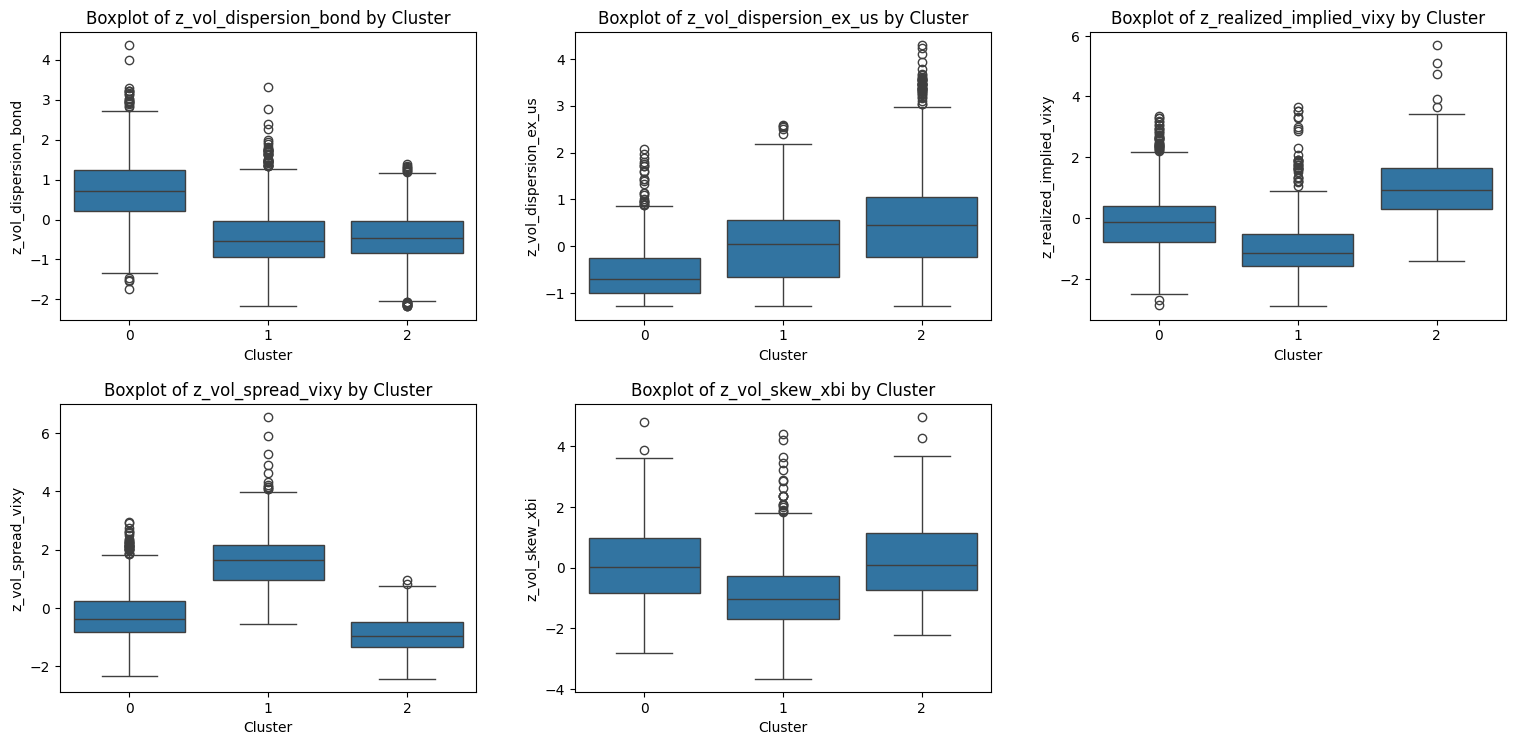

In [ ]:
# Assign cluster labels to the original data
df_clustered = df_pivot_clean.copy()
df_clustered['Cluster'] = gmm_labels

# Create boxplots: one subplot per feature in a grid (2 cols)
num_features = df_pivot_clean.shape[1]
ncols = 3
nrows = math.ceil(num_features / ncols)

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 4 * nrows))
fig.tight_layout(pad=4.0)

# Flatten axes array for easy iteration
axs = axs.flatten()

for i, column in enumerate(df_pivot_clean.columns):
    sns.boxplot(x='Cluster', y=column, data=df_clustered, ax=axs[i])
    axs[i].set_title(f'Boxplot of {column} by Cluster')
    axs[i].set_xlabel('Cluster')
    axs[i].set_ylabel(column)

# Hide any empty subplots if the number of features is odd
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.show()


In [106]:
# Print percentage of data points in each cluster
cluster_counts = pd.Series(gmm_labels).value_counts(normalize=True) * 100
print("\n Percentage of data points in each cluster:")
for cluster_id, percentage in cluster_counts.sort_index().items():
    print(f"Cluster {cluster_id}: {percentage:.2f}%")


 Percentage of data points in each cluster:
Cluster 0: 39.61%
Cluster 1: 25.73%
Cluster 2: 34.66%


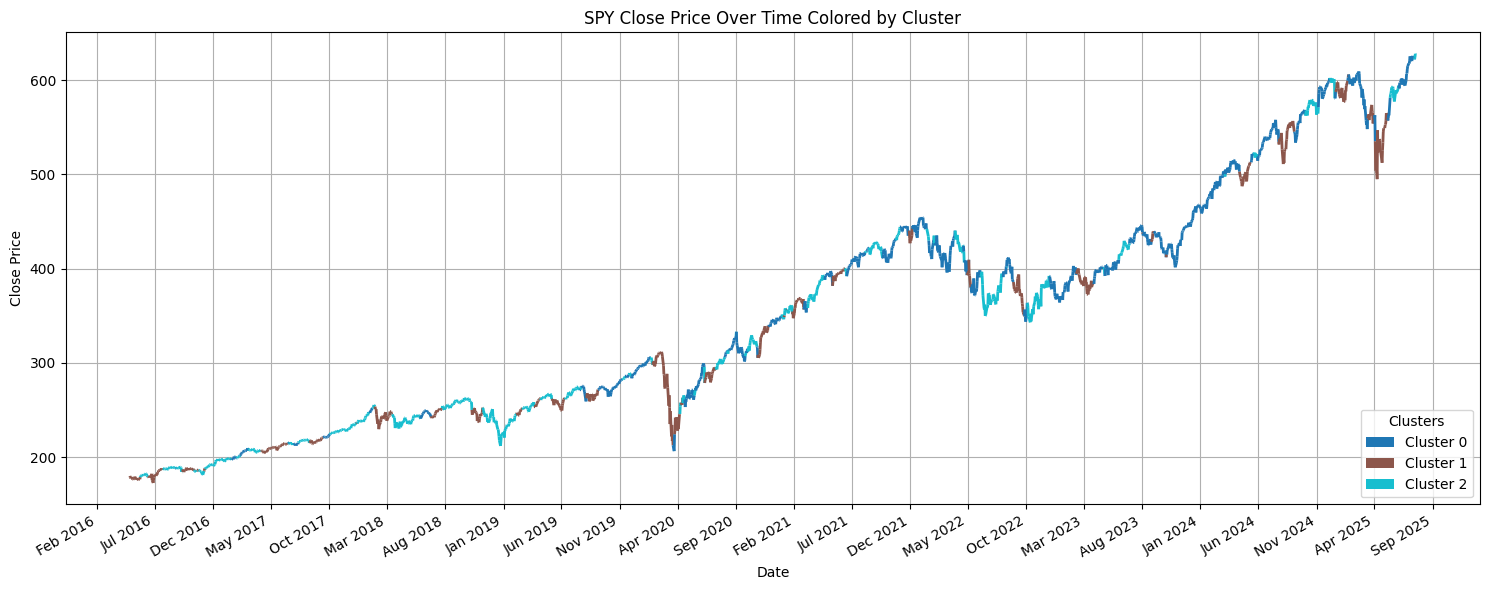

In [ ]:
req = StockBarsRequest(
    symbol_or_symbols = 'SPY',
    timeframe=TimeFrame(amount = 1, unit = TimeFrameUnit.Day), 
    start = earliest_date,                    
    limit = None,    
    adjustment=Adjustment('all') # adjust for splits and dividends                                           
)
df_2_plot = stock_historical_data_client.get_stock_bars(req).df.reset_index().set_index('timestamp')
df_2_plot = df_2_plot.sort_values(by=['symbol', 'timestamp']) # Ensure sorted for correct rolling calcs
# remove first days that do not have cluster
df_2_plot =  df_2_plot[nan_range_start:]

# Merge cluster labels into df_2_plot
df_with_clusters = df_2_plot.copy()
# Prepare the dataframe with timestamp index and cluster labels
df_time_clustered = df_pivot_clean.copy()
df_time_clustered['Cluster'] = gmm_labels
df_time_clustered = df_time_clustered.sort_index()  # Ensure it's sorted by time

df_with_clusters['Cluster'] = df_time_clustered.loc[df_2_plot.index, 'Cluster'].values

# Prepare data for colored line segments
dates = df_with_clusters.index
close_prices = df_with_clusters['close'].values
clusters = df_with_clusters['Cluster'].values

# Create line segments between consecutive points
points = np.array([dates, close_prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Assign colors based on clusters (normalize for color mapping)
colors = clusters[:-1]  # Use starting point's cluster for each segment
cmap = plt.get_cmap("tab10")  # Choose a categorical colormap
norm = plt.Normalize(min(clusters), max(clusters))

# Convert datetime index to Matplotlib's float format
date_nums = mdates.date2num(dates)
# Create line segments with numeric date values
points = np.array([date_nums, close_prices]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create the line collection
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(colors)
lc.set_linewidth(2)

# Plot with colored lines for clusters using LineCollection
fig, ax = plt.subplots(figsize=(15, 6))
ax.add_collection(lc)
ax.autoscale()
ax.set_title("SPY Close Price Over Time Colored by Cluster")
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")
ax.grid(True)

# Format month and year
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=5))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

fig.autofmt_xdate()  # Auto-rotate labels for better visibility

# Build a legend for discrete clusters
unique_clusters = np.unique(clusters)
legend_elements = [Patch(facecolor=cmap(norm(c)), label=f'Cluster {c}') for c in unique_clusters]
ax.legend(handles=legend_elements, loc="lower right", title="Clusters")


plt.tight_layout()
plt.show()